## Create CiS toy model class

Model is single hidden layer: x -> n_h -> y  (size of x and y is equal)

W1 = (n_h, x), W2 = (y, n_h)
x = 3 features (should be able to vary this)
y = abs(x) 
n_h = 2 neurons (should be able to vary this)
loss = MSE

- Vary the activation function used in each layer (e.g. ReLU or identity, by default, ReLU)

- Vary the bias value used in each layer (all equal or specific values)

- Vary the feature sparsity (all equal or specific values (e.g. function of index))

- Vary the feature importance (all equal or specific values (e.g. function of index))

- Vary the loss fn

- Optional: Vary optimizer and lr schedule

In [2]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import numpy as np
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

In [3]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [4]:
@dataclass
class CisConfig:
    n_instances: int = 2
    n_feat: int = 2
    n_hidden: int = 4
    act_fn: List[Callable] = field(default_factory=lambda: [F.relu, F.relu])
    b1: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    b2: str | Float[t.Tensor, "inst hid"] = field(default_factory=lambda: "0")
    feat_sparsity: float| t.Tensor = 0
    feat_importance: float | t.Tensor = 1.0
    optimizer: Callable = t.optim.Adam

    def __post_init__(self):
        """Ensure attribute values are valid."""
        pass

In [5]:
class Cis(nn.Module):
    """Computation in Superposition toy model."""

    # Some attribute type hints
    W1: Float[t.Tensor, "inst feat hid"]
    W2: Float[t.Tensor, "inst hid feat"]
    b1: Float[t.Tensor, "inst hid"]
    b2: Float[t.Tensor, "inst feat"]
    s: Float[t.Tensor, "inst feat"]  # feature sparsity
    i: Float[t.Tensor, "inst feat"]  # feature importance


    def __init__(self, cfg: CisConfig):
        """Initializes model params."""
        super().__init__()
        self.cfg = cfg

        # Model Weights
        self.W1 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_feat, cfg.n_hidden)))
        self.W2 = nn.Parameter(nn.init.xavier_normal_(t.empty(cfg.n_instances, cfg.n_hidden, cfg.n_feat)))

        # Model Biases
        # self.b1 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_hidden)) if cfg.b1 == "0" else cfg.b1
        self.b1 = t.zeros(cfg.n_instances, cfg.n_hidden) if cfg.b1 == "0" else cfg.b1
        self.b2 = nn.Parameter(t.zeros(cfg.n_instances, cfg.n_feat)) if cfg.b2 == "0" else cfg.b2

        # Sparsities
        if isinstance(cfg.feat_sparsity, float):
            self.s = t.full((cfg.n_instances, cfg.n_feat), cfg.feat_sparsity)
        else:
            self.s = cfg.feat_sparsity

        # Importances
        if isinstance(self.cfg.feat_importance, float):
            self.i = t.full((self.cfg.n_feat,), self.cfg.feat_importance)
        elif callable(self.cfg.feat_importance):
            self.i = cfg.feat_importance


    def gen_batch(self, batch_sz: int) -> Float[t.Tensor, "batch inst feat"]:
        """Generates a batch of data (sparse feature vals on [-1, 1])."""

        # Randomly generate features vals, and for each, randomly determine which samples are non-zero
        x = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) * 2 - 1  # [-1, 1]
        is_active = t.rand(batch_sz, self.cfg.n_instances, self.cfg.n_feat) < (1 - self.s)
        
        return x * is_active


    def forward(
        self, x: Float[t.Tensor, "batch inst feat"], fx: Callable = t.abs
    ) -> Float[t.Tensor, ""]:
        """Runs a forward pass through model returning the loss."""

        # Hidden layer
        h = einsum(x, self.W1, "batch inst feat, inst feat hid -> batch inst hid")
        h = self.cfg.act_fn[0](h + self.b1)

        # Output layer
        y = einsum(h, self.W2, "batch inst hid, inst hid feat -> batch inst feat")
        y = self.cfg.act_fn[1](y + self.b2)

        # Compute weighted MSE loss
        y_true = fx(x)
        loss = reduce(((y - y_true) ** 2 * self.i), "batch inst feat -> ", "mean")

        return loss


    def optimize(
        self, optimizer: t.optim.Optimizer, batch_sz: int, steps: int, logging_freq: int
    ):
        """Optimizes the model."""

        losses = []
        pbar = tqdm(range(steps), desc="Training")

        for step in pbar:
            x = self.gen_batch(batch_sz)
            loss = self.forward(x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Log progress
            if step % logging_freq == 0 or (step + 1 == steps):
                losses.append(loss.item())
                pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        return losses

## Verify toy model with `n_hidden = 2 * len(x)` learns `abs(x)` function

For` len(x) = 3` and `n_hidden = 6`, with this forward pass:

$$
h = ReLU(W_1x)
y' = ReLU(W_2h + b)
$$

we get something like this:

![6 h 3 f learned abs](./assets/x3n6_learned_abs.png)


In [43]:
"""Create model and inspect parameters."""

config = CisConfig(n_instances=1, n_feat=3, n_hidden=6, feat_sparsity=0, feat_importance=1.0)
model = Cis(config)
print("Model parameters:", [name for name, _ in model.named_parameters()])

Model parameters: ['W1', 'W2', 'b2']


In [44]:
"""Train model."""

batch_sz = 128
steps = 5000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.2775467336177826,
 0.06092573329806328,
 0.04675912857055664,
 0.031617019325494766,
 0.025106070563197136,
 0.021257920190691948,
 0.018048984929919243,
 0.016000734642148018,
 0.01686180755496025,
 0.0022512285504490137,
 0.0005147915799170732]

In [45]:
"""Inspect model parameters."""

# Ensure bias in layer1 is 0 (shouldn't be learned in this case, to fully replicate the paper)
print(f"{model.b1=}")

model.b1=tensor([[0., 0., 0., 0., 0., 0.]])


In [50]:
def plot_weight_bars(W: t.Tensor) -> plt.Figure:
    """Plot weights from each hidden neuron as stacked bars across input features."""
    W = asnumpy(W)
    assert len(W.shape) == 2
    n_hidden, n_feat = W.shape  # assume weights in shape of layer1 weights
    x = np.arange(n_feat)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bottom = np.zeros(n_feat)
    for h in range(n_hidden):
        ax.bar(x, W[h], bottom=bottom, label=f"Neuron {h}")
        bottom += W[h]
    
    ax.set_xlabel("Input Features")
    ax.set_ylabel("Weight Value")
    ax.legend()
    
    return fig

model.W1=Parameter containing:
tensor([[[-1.2309e+00,  5.3197e-02, -1.5302e-05, -3.6782e-05,  3.5280e-02,
           1.1324e+00],
         [-1.1474e-02, -7.0224e-03,  9.1078e-01, -9.1741e-01, -7.8149e-03,
          -9.2100e-03],
         [ 3.3353e-01,  1.0820e+00, -1.0552e-03, -1.3383e-03, -1.1978e+00,
           3.3162e-01]]], requires_grad=True)
model.W2=Parameter containing:
tensor([[[ 8.6718e-01,  1.4494e-04,  3.3727e-02],
         [-3.4835e-01,  1.2096e-03,  9.2179e-01],
         [-4.9051e-03,  1.0979e+00,  9.5194e-03],
         [-2.7209e-02,  1.0899e+00, -5.0482e-03],
         [ 2.0355e-01, -9.2651e-04,  8.3512e-01],
         [ 9.5154e-01,  1.2260e-04, -3.2506e-02]]], requires_grad=True)


Text(0.5, 0.98, 'Layer 2 weights per feature')

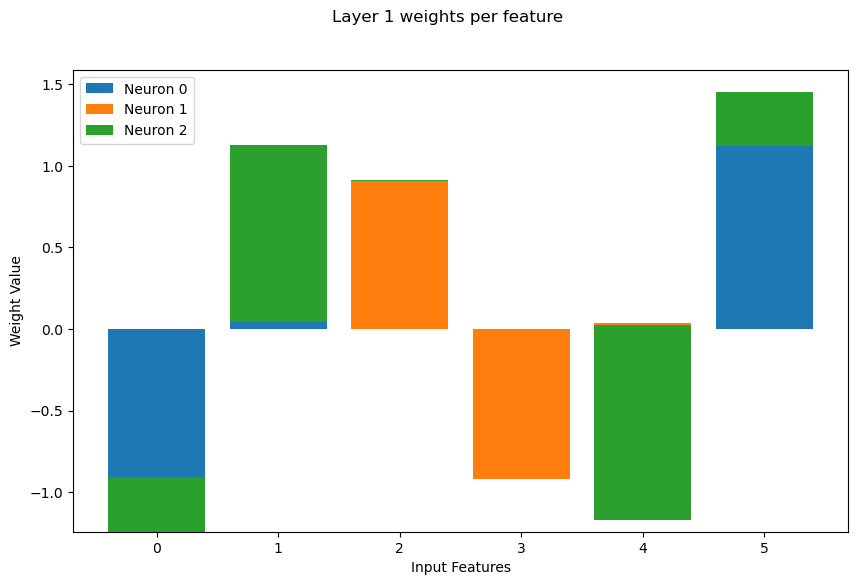

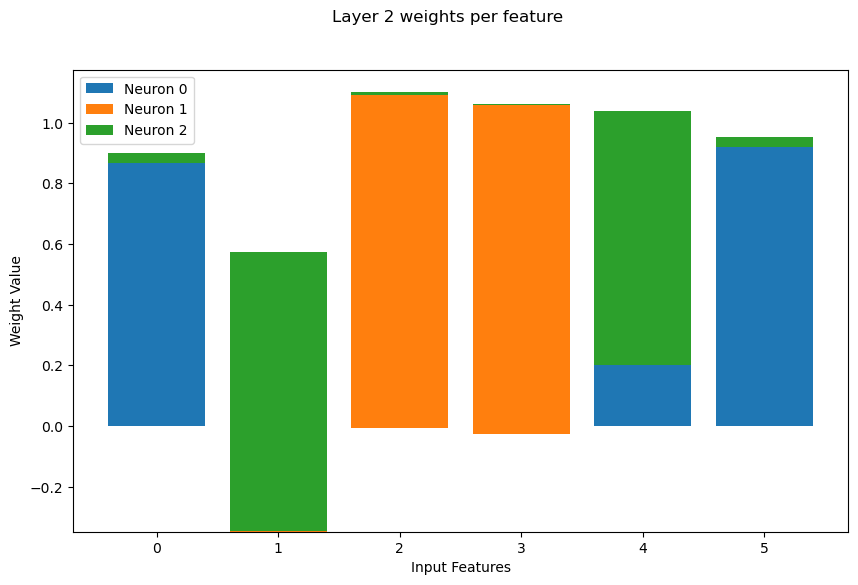

In [51]:
"""Visualize the learned weights."""

print(f"{model.W1=}")
print(f"{model.W2=}")

fig_w1 = plot_weight_bars(model.W1[0])
fig_w1.suptitle("Layer 1 weights per feature")

fig_w2 = plot_weight_bars(model.W2[0].T)
fig_w2.suptitle("Layer 2 weights per feature")

## See if we can learn `abs(x)` with `n_hidden < 2 * len(x)` (CiS)

In [53]:
config = CisConfig(n_instances=1, n_feat=6, n_hidden=10, feat_sparsity=0.9, feat_importance=1.0)
model = Cis(config)
print("Model parameters:", [name for name, _ in model.named_parameters()])

batch_sz = 128
steps = 5_000
logging_freq = steps // 10

model.optimize(t.optim.Adam(model.parameters()), batch_sz, steps, logging_freq)

Model parameters: ['W1', 'W2', 'b2']


Training:   0%|          | 0/5000 [00:00<?, ?it/s]

[0.03118821233510971,
 0.010462974198162556,
 0.007627494633197784,
 0.005136554129421711,
 0.0035639668349176645,
 0.0022742915898561478,
 0.005098868627101183,
 0.004648351576179266,
 0.0032333347480744123,
 0.003444904228672385,
 0.0042333598248660564]

Now, when we visualize the learned weights, see if we get something like the "asymmetric Superposition motif" shown here:

![10 h 6 f learned abs](./assets/cis_x6n10_learned_abs.png)

Text(0.5, 0.98, 'Layer 2 weights per feature')

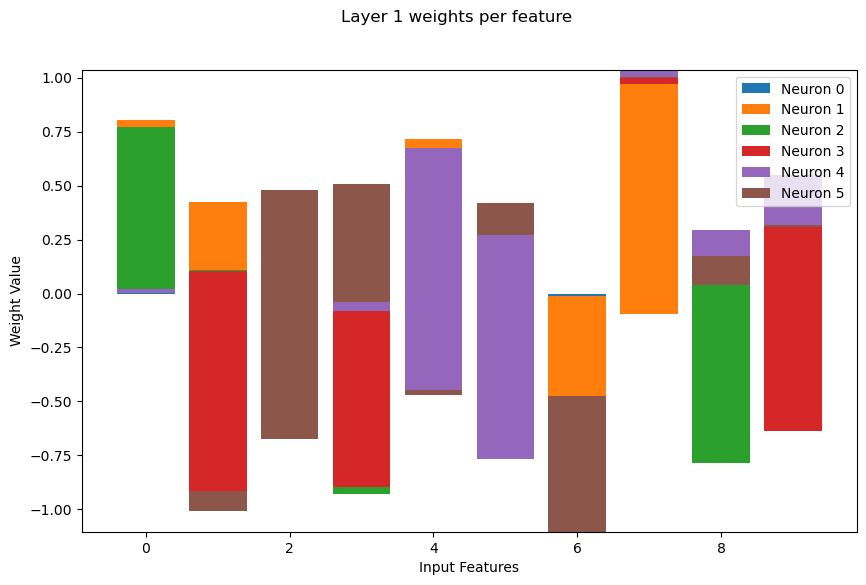

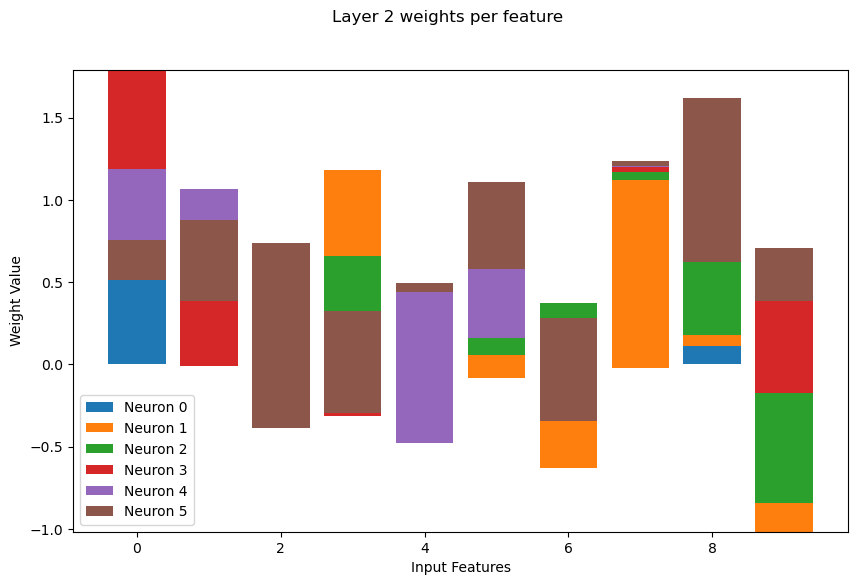

In [54]:
"""Visualize the learned weights."""

fig = plot_weight_bars(model.W1[0])
fig.suptitle("Layer 1 weights per feature")

fig = plot_weight_bars(model.W2[0].T)
fig.suptitle("Layer 2 weights per feature")

## See poly vs monsemanticity as a function of sparsity with `len(x) = 100`, `n_hidden = 40`

## See poly vs monsemanticity as a function of sparsity **and importance** with `len(x) = 100`, `n_hidden = 40`